# Predicting Salaries for MLB Players
### Kevin Payton
### PSTAT 131 Fall 24

---
## MLB Information

---
## Loading our Data and Libraries

In [600]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [601]:
master = pd.read_csv('Master.csv')
salaries = pd.read_csv('Salaries.csv')
batting_stats = pd.read_csv('Batting.csv')
fielding = pd.read_csv('Fielding.csv')

---
## Exploring, Merging, and Tidying our Data

First I will import all my libraries:

I will first import my data I have decided on so far. Everything comes from Kaggle at the following link: https://www.kaggle.com/datasets/open-source-sports/baseball-databank?resource=download. So far I have decided on using the Master.csv, Salaries.csv, and Batting.csv files which all have data from 1871 through 2015, but I will only be working with data from year 1990 to 2015. The Master.csv file contains personal information of all the players in the dataset, but I will only be using this to gather the names of players to make importing any future data easier since currently my datasets rely on player IDs. The Salaries.csv file contains team and league information, as well as the salary players have for any given year. Finally, my Batting.csv file contains various batting statistics for players.

In [602]:
master['nameFull'] = master['nameFirst'] + ' ' + master['nameLast']
names = master[['playerID', 'nameFull']]
print(names.shape)

salaries_post_1990 = salaries[salaries['yearID'] >= 1990]
print(salaries_post_1990.shape)

merged_data = pd.merge(salaries_post_1990, names, on='playerID', how='inner')
print(merged_data.shape)

merged_data_left = pd.merge(salaries_post_1990, names, on='playerID', how='left')
print(merged_data_left.shape)

(18846, 2)
(22286, 5)
(22278, 6)
(22286, 6)


After importing my Master.csv file, I first decided to make a full name column because the player's first and last names were separated. I then removed all columns except the playerID and nameFull to make the merging with salaries easier since all the other columns were unneeded. This left us with 18846 rows and 2 columns, with the rows each representing players. We are left with so many because we currently still have values from every player that has played since 1871 through 2015, but all those prior to 1990 will be removed once we merge with our salaries dataset. 

I then imported my Salaries.csv file and filtered out all player data prior to 1990 to simplify things, leaving us with 22286 rows and 5 columns containing simple data about a player, the team they started the season and its league, as well as the year and their salary. This file does not contain information on if a player was traded during the year, because their salary stays the same. This is an issue I might have later when dealing with the batting information, because there might be multiple rows for the same player during a given year.

I was then able to finally merge the two datasets together, and I did so with both a left and an inner join so I could see if we were missing any information on any player's names. As you can see above, we were missing 8 player's names from the names data frame so I will create a function to discover the index of these players, as well as their playerID so I can try and find some more information about them in our Master.csv file.

In [603]:
null_data = merged_data_left['nameFull'].isnull()
missing_names = []

for ind in merged_data_left.index:
    if null_data.iloc[ind] == True:
        missing_names.append(merged_data_left.loc[ind, 'playerID'])
    
print(missing_names)

['harriwi10', 'castiru02', 'rosajo01', 'arrueba01', 'furcara02', 'castiru02', 'rosajo01', 'harriwi10']


In [604]:
for playerid in missing_names:
    print(master.loc[master['playerID'] == playerid])

Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, bi

Unfortunately, I was unable to find these names simply from going through my full Master.csv file, so I will have to do some extra research in case the ID was simply input wrong.

I was first able to discover that the player with the ID 'harriwi10' was Will Harris and was given the ID 'harriwi02' in both Master.csv and Batting.csv. The player with the ID 'castiru02' was Rusney Castillo with the ID 'castiru01'. The player with the ID 'rosajo01' was Jorge De La Rosa and also had data under the ID 'delarjo01'. The player with the ID 'arrueba01' was Erisbel Arruebarrena who also had data under the ID 'arrueer01'. Finally, the player with the ID 'furcara02' was Rafael Furcal who also had data under 'furcara01'.

In [605]:
salaries_post_1990.loc[salaries_post_1990.playerID == 'harriwi10', 'playerID'] = 'harriwi02'
salaries_post_1990.loc[salaries_post_1990.playerID == 'castiru02', 'playerID'] = 'castiru01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'rosajo01', 'playerID'] = 'delarjo01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'arrueba01', 'playerID'] = 'arrueer01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'furcara02', 'playerID'] = 'furcara01'

final_merged_data = pd.merge(salaries_post_1990, names, on='playerID', how='inner')

Now the set of data containg the player names and salaries should be all cleaned up and ready, so we just need to work on the batting stats and getting everything merged together.

In [606]:
batting_stats = batting_stats[batting_stats['yearID'] >= 1990]
print(batting_stats.shape)
print(batting_stats.isnull().sum())

(33924, 22)
playerID       0
yearID         0
stint          0
teamID         0
lgID           0
G              0
AB          2049
R           2049
H           2049
2B          2049
3B          2049
HR          2049
RBI         2049
SB          2049
CS          2049
BB          2049
SO          2049
IBB         2049
HBP         2049
SH          2049
SF          2049
GIDP        2049
dtype: int64


In [607]:
batting_stats.dropna(subset=['AB'], inplace=True)

We had a lot of null values for our batting stats, presumably for players who were pitchers and weren't required to bat, so I removed all of those. This will make it easier to work with our data. Now all I need to do is combine the rows for players who were traded during the season

In [608]:
stats = ['G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP']
new_batting = batting_stats.groupby(['playerID', 'yearID'])[stats].sum().reset_index()
new_merged = pd.merge(new_batting, final_merged_data, on=['playerID', 'yearID'], how='inner')

Now all our batting data is grouped together by year and player and we were able to merge our data sets together, leaving us with 20337 rows and 23 columns. Now we can add all the positions to remove pitchers because they should not be judged based on their battings stats.

In [609]:
new_fielding = fielding[['playerID', 'yearID', 'POS', 'G']]
new_fielding = new_fielding[new_fielding['yearID'] >= 1990]
fielding_counts = new_fielding.groupby(['playerID', 'yearID', 'POS'])['G'].sum().reset_index()
fielding_counts.sort_values(by=['playerID','yearID','G'], ascending=False, inplace=True)
fielding_counts.drop_duplicates(subset=['playerID', 'yearID'], keep='first', inplace=True)
fielding_counts.drop('G', axis=1, inplace=True)

Due to the fact that players can play multiple positions in a given season, to add the position data I first had to sum up all the games played for a specific positon for each given year for each player. I was then able to sort these new values and drop all the rows for positions that weren't the most played for every player. I then finally removed our games played column because all we wanted was every player's most played position.

In [610]:
final_merge = pd.merge(fielding_counts, new_merged, on=['playerID', 'yearID'], how='inner')
final_no_pitchers = final_merge[final_merge.POS != 'P']
final_data = final_no_pitchers[['playerID', 'nameFull', 'yearID', 'POS', 'salary', 'teamID',
                        'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
                        'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']]
print(final_data.shape)
print(final_data.columns)

(11399, 24)
Index(['playerID', 'nameFull', 'yearID', 'POS', 'salary', 'teamID', 'lgID',
       'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')


In [611]:
final_data['POS'] = final_data['POS'].astype('category')
final_data['lgID'] = final_data['lgID'].astype('category')
final_data['teamID'] = final_data['teamID'].astype('category')

After removing pitchers and moving around our columns, we are finally left with 11399 rows and 24 columns containing batting and salary information about most MLB players from 1990 to 2015.

---
## Exploratory Data Analysis

In [622]:
print(final_data.shape)
print(final_data.loc[final_data.G <= 50])
final_data.describe()

(11399, 24)
        playerID         nameFull  yearID POS  salary teamID lgID   G     AB  \
2      zupcibo01       Bob Zupcic    1991  OF  100000    BOS   AL  18   25.0   
10     zuletju01     Julio Zuleta    2001  1B  200000    CHN   NL  49  106.0   
11     zuberjo01        Jon Zuber    1996  1B  109000    PHI   NL  30   91.0   
12     zoskyed01      Eddie Zosky    1992  SS  109000    TOR   AL   8    7.0   
21     zobribe01      Ben Zobrist    2007  SS  383400    TBA   AL  31   97.0   
...          ...              ...     ...  ..     ...    ...  ...  ..    ...   
20235  abernbr01  Brent Abernathy    2003  2B  300000    TBA   AL  12   34.0   
20245  abbotku01      Kurt Abbott    2001  2B  600000    ATL   NL   6    9.0   
20253  abbotku01      Kurt Abbott    1993  LF  109000    OAK   AL  20   61.0   
20255  abbotje01      Jeff Abbott    2001  OF  300000    FLO   NL  28   42.0   
20257  abbotje01      Jeff Abbott    1999  LF  255000    CHA   AL  17   57.0   

          R  ...   RBI   SB

,yearID,salary,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,11399.000000,1.139900e+04,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000
mean,2002.173261,2.441237e+06,99.375647,321.542328,44.382490,86.140363,16.896833,1.822265,9.848759,42.355382,6.188964,2.636810,31.968681,59.228967,2.649706,3.105272,1.975875,2.785157,7.403018
std,7.449113,3.743727e+06,44.629369,187.194851,31.229713,55.574946,11.909595,2.277508,10.100127,31.764585,9.512116,3.250797,24.997069,38.095244,4.112925,3.545727,2.907089,2.536258,5.637283
min,1990.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1996.000000,3.250000e+05,66.000000,156.000000,18.000000,37.000000,7.000000,0.000000,2.000000,16.000000,0.000000,0.000000,12.000000,29.000000,0.000000,1.000000,0.000000,1.000000,3.000000
50%,2002.000000,7.250000e+05,106.000000,320.000000,40.000000,82.000000,15.000000,1.000000,7.000000,36.000000,2.000000,2.000000,27.000000,54.000000,1.000000,2.000000,1.000000,2.000000,6.000000
75%,2009.000000,3.000000e+06,139.000000,489.000000,68.000000,133.000000,26.000000,3.000000,15.000000,63.000000,8.000000,4.000000,46.000000,84.000000,4.000000,4.000000,3.000000,4.000000,11.000000
max,2015.000000,3.300000e+07,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,78.000000,28.000000,232.000000,223.000000,120.000000,34.000000,39.000000,17.000000,32.000000


<Axes: >

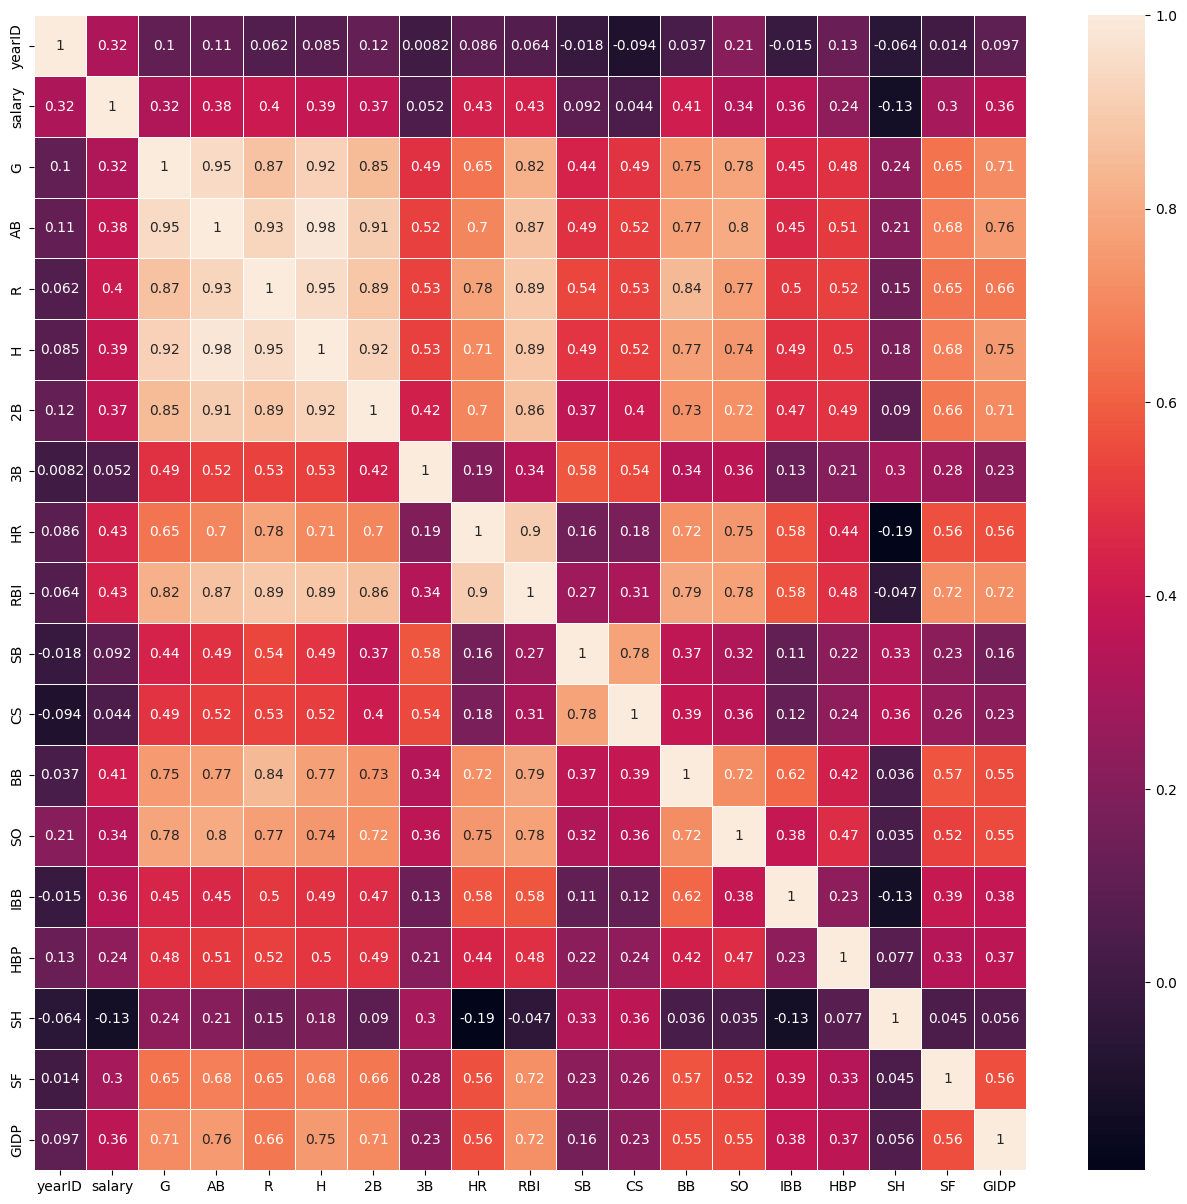

In [613]:
plt.figure(figsize=(16, 15))
sns.heatmap(final_data.corr(numeric_only=True), annot=True, linewidth=.5)